# Problem Description

This is an example of a holonomic system that includes both particles and rigid bodies with contrbuting forces and torques, some of which are specified forces and torques.

![](multidof-holonomic.png)

Generalized coordinates:
- $q_1$: Lateral distance of block from wall.
- $q_2$: Angle of the compound pendulum from vertical.
- $q_3$: Angle of the simple pendulum from the compound pendulum.

Generalized speeds:
- $u_1 = \dot{q}_1$: Lateral speed of block.
- $u_2 = {}^N\bar{v}^{Bo} \cdot \hat{b}_x$
- $u_3 = \dot{q}_3$: Angular speed of C relative to B.

The block and the bob of the simple pendulum are modeled as particles and $B$ is a rigid body.

Loads:

- gravity acts on $B$ and $P_c$.
- a linear spring and damper act on $P_{ab}$
- a rotational linear spring acts on $C$ relative to $B$
- specified torque $T$ acts on $B$ relative to $N$
- specified force $F$ acts on $P_{ab}$

In [1]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting()

# Generalized coordinates

In [2]:
q1, q2, q3 = me.dynamicsymbols('q1, q2, q3')

# Generalized speeds

In [3]:
u1, u2, u3 = me.dynamicsymbols('u1, u2, u3')

# Specified Inputs

In [4]:
F, T = me.dynamicsymbols('F, T')

# Constants

In [5]:
k, c, ma, mb, mc, IB_bo, l, kT, g = sm.symbols('k, c, m_a, m_b, m_c, I_{B_bo}, l, k_T, g')
k, c, ma, mb, mc, IB_bo, l, kT, g

# Reference Frames

In [6]:
N = me.ReferenceFrame('N')

In [7]:
B = N.orientnew('B', 'Axis', (q2, N.z))

In [8]:
C = B.orientnew('C', 'Axis', (q3, N.z))

# Points

In [9]:
O = me.Point('O')

In [10]:
Pab = O.locatenew('P_{ab}', q1 * N.x)

In [11]:
Bo = Pab.locatenew('B_o', - 2 * l / 3 * B.y)

In [12]:
Pbc = Pab.locatenew('P_{bc}', -l * B.y)

In [13]:
Pc = Pbc.locatenew('P_c', -l * C.y)

In [14]:
Pc.pos_from(O)

# Linear Velocities

In [15]:
Pab.set_vel(N, Pab.pos_from(O).dt(N))
Pab.vel(N)

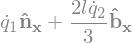

In [16]:
Bo.v2pt_theory(Pab, N, B)

In [17]:
Pbc.v2pt_theory(Pab, N, B)

In [18]:
Pc.v2pt_theory(Pbc, N, C)

# Kinematic Differential Equations

One non-trivial generalized speed definition is used.

In [19]:
u1_eq = sm.Eq(u1, Pab.vel(N).dot(N.x))
u2_eq = sm.Eq(u2, Bo.vel(N).dot(B.x))
u3_eq = sm.Eq(u3, C.ang_vel_in(B).dot(B.z))

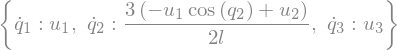

In [20]:
qdots = sm.solve([u1_eq, u2_eq, u3_eq], q1.diff(), q2.diff(), q3.diff())
qdots

Substitute expressions for the $\dot{q}$'s.

In [21]:
Pab.set_vel(N, Pab.vel(N).subs(qdots).simplify())
Pab.vel(N)

In [22]:
Bo.set_vel(N, Bo.vel(N).subs(qdots).express(B).simplify())
Bo.vel(N)

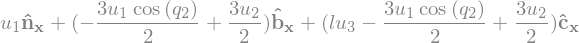

In [23]:
Pc.set_vel(N, Pc.vel(N).subs(qdots).simplify())
Pc.vel(N)

# Angular Velocities

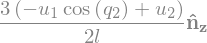

In [24]:
B.set_ang_vel(N, B.ang_vel_in(N).subs(qdots).simplify())
B.ang_vel_in(N)

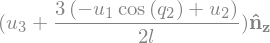

In [25]:
C.set_ang_vel(B, u3 * N.z)
C.ang_vel_in(N)

# Mass and Inertia

In [26]:
ma, mc

In [27]:
IB = me.inertia(B, 0, 0, IB_bo)
IB

# Loads (forces and torques)

Make sure these are defined in terms of the q's and u's.

In [28]:
Rab = (F - k*q1 - c*qdots[q1.diff()]) * N.x
Rab

In [29]:
Rbo = -(mb*g)*N.y
Rbo

In [30]:
Rc = -(mc*g)*N.y
Rc

In [31]:
TB = (T + kT*q3)*N.z
TB

Equal and opposite torque on $C$ from $B$.

In [32]:
TC = -kT*q3*N.z
TC

# Kane's Equations

In [33]:
kdes = [u1_eq.rhs - u1_eq.lhs,
        u2_eq.rhs - u2_eq.lhs,
        u3_eq.rhs - u3_eq.lhs]

In [34]:
block = me.Particle('block', Pab, ma)
pendulum = me.RigidBody('pendulum', Bo, B, mb, (IB, Bo))
bob = me.Particle('bob', Pc, mc)

bodies = [block, pendulum, bob]

Loads are a list of (force, point) or reference (frame, torque) 2-tuples:

In [35]:
loads = [(Pab, Rab),
         (Bo, Rbo),
         (Pc, Rc),
         (B, TB),
         (C, TC)]

In [36]:
kane = me.KanesMethod(N, (q1, q2, q3), (u1, u2, u3), kd_eqs=kdes)

In [37]:
fr, frstar = kane.kanes_equations(bodies, loads=loads)

# Simulation

In [38]:
from pydy.system import System
import numpy as np  # provides basic array types and some linear algebra
import matplotlib.pyplot as plt  # used for plots

In [39]:
sys = System(kane)

Define numerical values for each constant using a dictionary. Make sure units are compatible!

In [40]:
sys.constants = {ma: 1.0,  # kg
                 mb: 2.0,  # kg
                 mc: 1.0,  # kg
                 g: 9.81,  # m/s/s
                 l: 2.0,  # m
                 IB_bo: 2.0,  # kg*m**2
                 c: 10.0,  # kg/s
                 k: 60.0,  # N/m
                 kT: 10.0}  # N*m/rad

Provide an array of monotonic values of time that youd like the state values reported at.

In [41]:
sys.times = np.linspace(0.0, 20.0, num=500)

Set the initial conditions for each state.

In [42]:
sys.states

In [43]:
sys.initial_conditions = {q1: 1.0,  # m
                          q2: 0.0,  # rad
                          q3: 0.0,  # rad
                          u1: 0.0,  # m/s
                          u2: 0.0,  # rad/s
                          u3: 0.0}  # rad/s

There are several ways that the specified force and torque can be provided to the system. Here are three options, the last one is acutally used.

1) A single value can be provided to set the force and torque to be constant.

In [44]:
specifieds = {F: 0.0,  # N
              T: 1.0}  # N*m

2) The same thing as 1) can be done using an array.

In [45]:
specifieds = {(F, T): np.array([0.0, 1.0])}

3) A numerical function can be defined to calculate the input at a specific time.

In [46]:
def sin_f(x, t):
    """Returns the force F given the state vector x and time value t.
    
    Parameters
    ==========
    x : ndarray, shape(n,)
        The states in the order specified in System.states.
    t : float
        The value of time.
        
    Returns
    =======
    float
        The value of the force at time t.
    
    """
    return 1.0 * np.sin(2 * np.pi * t)

specifieds = {F: sin_f,  # N
              T: 1.0}  # N*m

4) A single numerical function can also be used for both.

In [47]:
def sin_f_t(x, t):
    return  np.array([5.0 * np.sin(2.0 * np.pi * t),
                      10.0 * np.cos(2.0 * np.pi * t)])

specifieds = {(F, T): sin_f_t}

In [48]:
sys.specifieds = specifieds

Integrate the equatiosn of motion and get the state trajectories `x`:

In [49]:
x = sys.integrate()

In [50]:
x.shape

# Plot Results

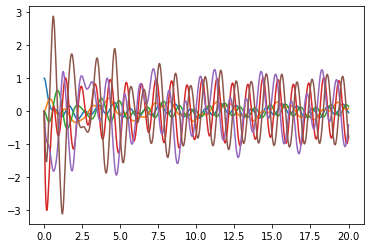

In [51]:
axes = plt.plot(sys.times, x)

Text(0, 0.5, 'Angle [deg]')

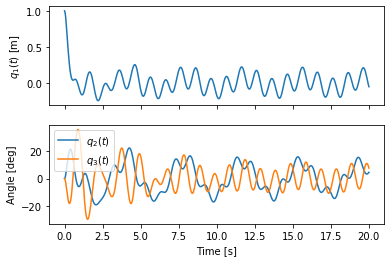

In [52]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(sys.times, x[:, 0])
axes[0].set_ylabel('{} [m]'.format(sm.latex(q1, mode='inline')))
axes[1].plot(sys.times, np.rad2deg(x[:, 1:3]))
axes[1].legend([sm.latex(q, mode='inline') for q in (q2, q3)])
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Angle [deg]')

# Animate with PyDy and pythreejs

In [53]:
from pydy.viz.shapes import Cube, Cylinder, Sphere, Plane
from pydy.viz.visualization_frame import VisualizationFrame
from pydy.viz import Scene

Define some PyDy shapes for each moving object you want visible in the scene. Each shape needs a unique name with no spaces.

In [54]:
block_shape = Cube(0.25, color='azure', name='block')
cpendulum_shape = Plane(l, l/4, color='mediumpurple', name='cpendulum')
spendulum_shape = Cylinder(l, 0.02, color='azure', name='spendulum')
bob_shape = Sphere(0.2, color='mediumpurple', name='bob')

Create a visualization frame that attaches a shape to a reference frame and point. Note that the center of the plane and cylinder for the two pendulums is at its geometric center, so two new points are created so that the position of those points are calculated instead of the mass centers, which are not at the geometric centers.

In [55]:
v1 = VisualizationFrame('block', N, Pab, block_shape)

v2 = VisualizationFrame('cpendulum',
                        B,
                        Pab.locatenew('Bc', -l/2*B.y),
                        cpendulum_shape)

v3 = VisualizationFrame('spendulum', 
                        C,
                        Pbc.locatenew('Cc', -l/2*C.y),
                        spendulum_shape)

v4 = VisualizationFrame('bob', C, Pc, bob_shape)

Create a scene with the origin point O and base reference frame N and the fully defined `System`.

In [56]:
scene = Scene(N, O, v1, v2, v3, v4, system=sys)

Make sure pythreejs is installed and then call `display_jupyter` for a 3D animation of the system.

In [57]:
scene.display_jupyter(axes_arrow_length=1.0)

It is then fairly simple to change constants, initial conditions, simulation time, or specified inputs and visualize the effects. Below the lateral spring is stretched more initially and when `display_jupyter()` is called the system equations are integrated with the new initial condition.

In [58]:
sys.initial_conditions[q1] = 5.0  # m

In [59]:
scene.display_jupyter(axes_arrow_length=1.0)